In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

from scikeras.wrappers import KerasClassifier

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC,Accuracy

import shap

from src.tensors.metrics import UtilMetric,F1Score
from src.tensors.losses import mean_regret
from src.tensors.utils import train
from src.tensors.models import create_ann_utadis_model,create_nn_model,create_guided_model
from src.viz import *
from src.utils import undersample,calculate_2d_differences,calculate_1d_differences,filter_data

C:\Users\Łukasz\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Car evaluation

#### Łukasz Andryszewski 151930

## Dataset

The dataset used is the Car Evalutaion dataset which can be found [here](https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets).

It consists of six criterions and four classes. The criterions are [1]: 
- price
- price of the maintenance
- number of doors
- capacity 
- size of luggage boot
- estimated safety

The criteria are normalized between 0 and 1.

Based on them the alternatives are assigned to four sorted classes, which are:
1. unacceptable 
2. acceptable
3. good
4. very good

However here they will be binerized between the second and third class into to:

1. Bad
2. Good

In [2]:
data = pd.read_csv("./data/monodata/car evaluation.csv",header=None)
features = len(data.columns)-1
crits = ["price","maintenance price","doors","capacity","size of luggage", "safety"]
data.columns = crits+["class"]#[f"crit_{i}" for i in range(features)]+["class"]
data

,price,maintenance price,doors,capacity,size of luggage,safety,class
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,0.0,0.5,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.5,0.0,1.0
4,1.0,1.0,0.0,0.0,0.5,0.5,1.0
...,...,...,...,...,...,...,...
1723,0.0,0.0,1.0,1.0,0.5,0.5,3.0
1724,0.0,0.0,1.0,1.0,0.5,1.0,4.0
1725,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1726,0.0,0.0,1.0,1.0,1.0,0.5,3.0


In [3]:
data.loc[data["class"]<=2,"class"] = 0
data.loc[data["class"]>=3,"class"] = 1
data_classless = data.drop(columns="class")
classes = 2
data

,price,maintenance price,doors,capacity,size of luggage,safety,class
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.5,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,0.0,0.5,0.0,0.0
4,1.0,1.0,0.0,0.0,0.5,0.5,0.0
...,...,...,...,...,...,...,...
1723,0.0,0.0,1.0,1.0,0.5,0.5,1.0
1724,0.0,0.0,1.0,1.0,0.5,1.0,1.0
1725,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1726,0.0,0.0,1.0,1.0,1.0,0.5,1.0


In [4]:
data.describe()

,price,maintenance price,doors,capacity,size of luggage,safety,class
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.077546
std,0.372786,0.372786,0.372786,0.408366,0.408366,0.408366,0.267534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
75%,0.750000,0.750000,0.750000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


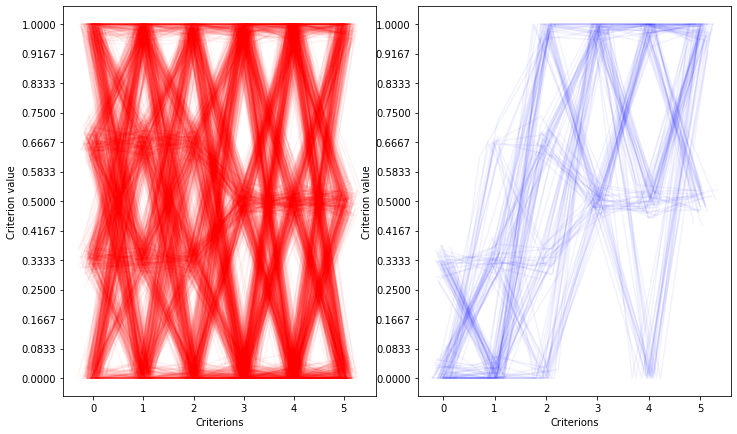

In [5]:
visualize_data(data_classless.to_numpy(),data["class"].to_numpy())

From the names and distribution of their values in different classes, it can be inferred that the price and maintaince price criterions are of cost types and the rest of the criterions are gain type.

In [6]:
show_class_counts(data["class"])

Class 0.0 occurences: 1594
Class 1.0 occurences: 134


The data is highly imbalanced, so there is a need for undersampling.

The data does not have a extensive range of values.

In [7]:
for col in data_classless:
    print(f"{col} values:", *np.sort(np.unique(data[col])))

price values: 0.0 0.333333 0.666667 1.0
maintenance price values: 0.0 0.333333 0.666667 1.0
doors values: 0.0 0.333333 0.666667 1.0
capacity values: 0.0 0.5 1.0
size of luggage values: 0.0 0.5 1.0
safety values: 0.0 0.5 1.0


So the possible combinations of the data are limited.

In [8]:
show_combinations(data_classless)

Possible combinations of data: 1728
Number of alternatives: 1728


The number of possible combinations of all values of the criterions and the number of alternatives is the same. Judging by that suspicious fact, it is safe to assume that the dataset is composed of all possible alternatives or that there is quite a number of repeated alternatives.

For the sake of performance and to avoid learning the most of the space of alternatives the first class needs to be heavily undersampled.

In [9]:
new_X,new_y = undersample(data_classless.to_numpy(),data["class"].to_numpy())

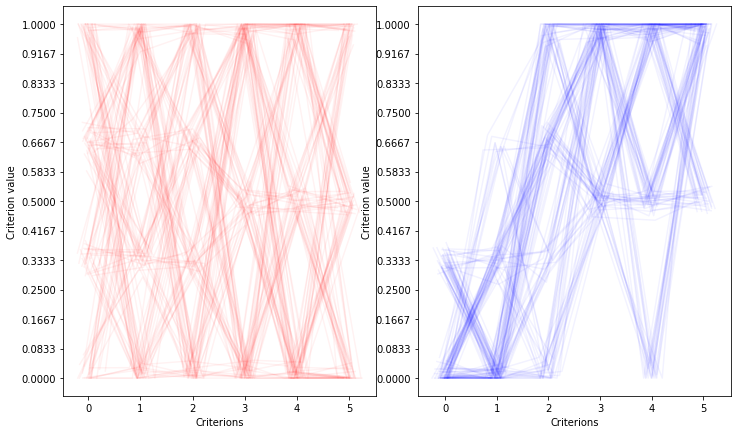

In [10]:
visualize_data(new_X,new_y)

Split into train and test data

In [11]:
X_train, X_rest, y_train, y_rest = train_test_split(new_X,new_y,test_size=0.40)
X_test, X_val, y_test, y_val = train_test_split(X_rest,y_rest,test_size=0.50)

### Criterions colleration

Is there some correlation between the criteria?

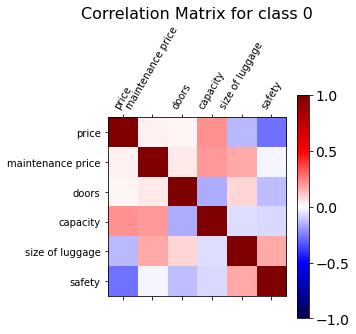

In [12]:
plot_corr(X_train[y_train==0],data_classless.columns,title="Correlation Matrix for class 0")

In class 0 there is not much correlation between the criterions, which is explained by the chaotic plot visualization.

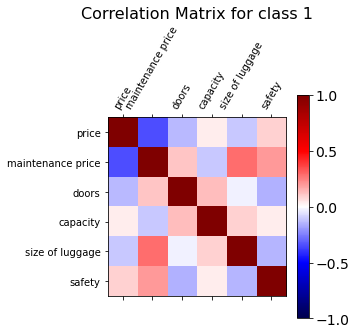

In [13]:
plot_corr(X_train[y_train==1],data_classless.columns,title="Correlation Matrix for class 1")

In class 1 however there is strong negative correlation between price and maintanance price. However not much when it comes to other criterions.

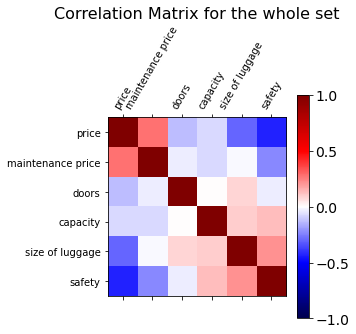

In [14]:
plot_corr(X_train,data_classless.columns,title="Correlation Matrix for the whole set")


Suprisingly correlation between price and maintance price becomes much higher for the entire set. There is also notable negative correlation of prices with safety.

The decisions of the models will be evaluated on 3 alternatives.

- ideal alternative,
- anti ideal alternative
- a mediocre alternative

In [15]:
alts = np.array([
    [0,0,1,1,1,1],
    [1,1,0,0,0,0],
    [0.5,0.5,0.5,0.5,0.5,0.5]
    ])

## RankSVM method

### Calculate differences between rows of different classes.

This is necessary for the RankSVM method.

In [16]:
X_train_difs = calculate_2d_differences(X_train)
X_test_difs = calculate_2d_differences(X_test)

y_train_difs = calculate_1d_differences(y_train)
y_test_difs = calculate_1d_differences(y_test)

In [17]:
X_train_filtered,y_train_filtered = filter_data(X_train_difs,y_train_difs)
X_test_filtered,y_test_filtered = filter_data(X_test_difs,y_test_difs)

In [18]:
rank_svm = LinearSVC(dual=True)#make_pipeline(StandardScaler(),LinearSVC())

rank_svm.fit(X_train_filtered,y_train_filtered)

LinearSVC(dual=True)

### RankSVM analysis

The model is able to achieve very high accuracy, which means its results are somewhat reliable.

In [19]:
print("Performance on train set:\n")
show_stats(rank_svm,X_train_filtered,y_train_filtered)
print("\nPerformance on test set:\n")
show_stats(rank_svm,X_test_filtered,y_test_filtered)

Performance on train set:

Accuracy: 98.3906%
F1 score: 98.3906%
AUC: 99.8688%

Performance on test set:

Accuracy: 96.6897%
F1 score: 96.6897%
AUC: 99.3923%


In [20]:
w = rank_svm.coef_[0]
print(f'Criteria coefficients:')
for name,w_i in zip(data_classless.columns,w):
    print(f"\t{name:20}: {w_i:.4e}")
b = rank_svm.intercept_[0]
print(f'Intercept {b}')

Criteria coefficients:
	price               : -2.3517e+00
	maintenance price   : -1.8563e+00
	doors               : 4.5513e-01
	capacity            : 1.5575e+00
	size of luggage     : 1.1943e+00
	safety              : 1.8930e+00
Intercept -1.0139788807950103e-06


As noted the first two criterions are cost criteria so they have negative weights in the model. The rest of them have positive coefficients as they are cost type. In the case of doors its interesting because the model sometimes gives it negative coefficients and sometimes positive. This might be due to low influence of the criterion.

The least important criterion is doors and most important are typically the prices and safety.

#### Boundaries between important criteria

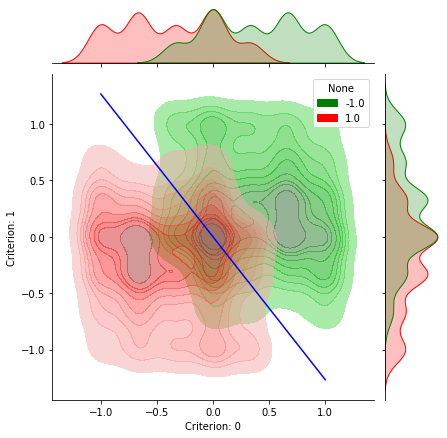

In [21]:
plot_density(X_test_filtered,y_test_filtered,0,1,w,b)

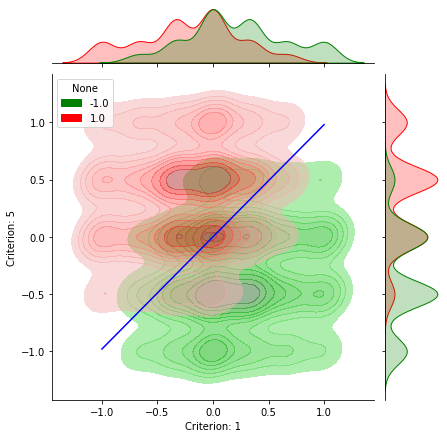

In [22]:
plot_density(X_test_filtered,y_test_filtered,1,5,w,b)

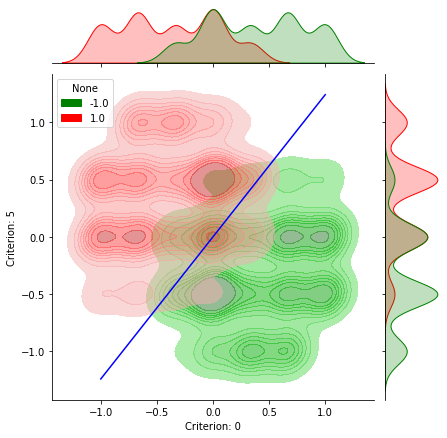

In [23]:
plot_density(X_test_filtered,y_test_filtered,0,5,w,b)

#### Decisions

Here decisions for the previously selected alternatives are presented

In [24]:
alts_dif = calculate_2d_differences(alts)
alts_same = calculate_1d_differences(np.arange(len(alts)))

alts_filtered,_ = filter_data(alts_dif,alts_same)
alts_pred = rank_svm.predict(alts_filtered)

In [25]:
def show_svm_difs(alts_filtered,alts_pred):
    names = ["ideal","anti","mid"]
    for i in range(len(alts_filtered)):
        alt_i = i//2
        sel = [0,1,2]
        sel.remove(alt_i)
        alt_j = sel[i%2]
        print(f"{names[alt_i]} - {names[alt_j]}: {alts_filtered[i]}")
        print(f"RankSVM({names[alt_i]},{names[alt_j]}):",alts_pred[i])
        print()

show_svm_difs(alts_filtered,alts_pred)

ideal - anti: [-1. -1.  1.  1.  1.  1.]
RankSVM(ideal,anti): 1.0

ideal - mid: [-0.5 -0.5  0.5  0.5  0.5  0.5]
RankSVM(ideal,mid): 1.0

anti - ideal: [ 1.  1. -1. -1. -1. -1.]
RankSVM(anti,ideal): -1.0

anti - mid: [ 0.5  0.5 -0.5 -0.5 -0.5 -0.5]
RankSVM(anti,mid): -1.0

mid - ideal: [ 0.5  0.5 -0.5 -0.5 -0.5 -0.5]
RankSVM(mid,ideal): -1.0

mid - anti: [-0.5 -0.5  0.5  0.5  0.5  0.5]
RankSVM(mid,anti): 1.0



To change their evaluations, pushing the price criterion to min or max marginal value has the highest chance of changing the value of the alternative. This is due to the high coefficient of the criterion.

From the coefficients of the model, the most important criteria to change are price, maintanance price and safety. 

The changes should cause the value to be over the unique ones of the data.

In [93]:
svm_difs = np.array([
    [1,0.4,0,0,0,-0.7],
    [-1,-1,0,0,0,1],
    [+0.5,0,0,0,0,1]
])
alts_dif2 = calculate_2d_differences(alts+svm_difs)

alts_filtered2,_ = filter_data(alts_dif2,alts_same)
alts_pred2 = rank_svm.predict(alts_filtered2)

print("Changed alternatives: ",alts+svm_difs,sep="\n")
print()
show_svm_difs(alts_filtered2,alts_pred2)

Changed alternatives: 
[[1.  0.4 1.  1.  1.  0.3]
 [0.  0.  0.  0.  0.  1. ]
 [1.  0.5 0.5 0.5 0.5 1.5]]

ideal - anti: [ 1.   0.4  1.   1.   1.  -0.7]
RankSVM(ideal,anti): -1.0

ideal - mid: [ 0.  -0.1  0.5  0.5  0.5 -1.2]
RankSVM(ideal,mid): -1.0

anti - ideal: [-1.  -0.4 -1.  -1.  -1.   0.7]
RankSVM(anti,ideal): 1.0

anti - mid: [-1.  -0.5 -0.5 -0.5 -0.5 -0.5]
RankSVM(anti,mid): 1.0

mid - ideal: [ 0.   0.1 -0.5 -0.5 -0.5  1.2]
RankSVM(mid,ideal): 1.0

mid - anti: [1.  0.5 0.5 0.5 0.5 0.5]
RankSVM(mid,anti): -1.0



The results don't agree with predictins as other criterions also were needed to be changed.

In [27]:
svm_explainer = shap.LinearExplainer(rank_svm,X_train_filtered)

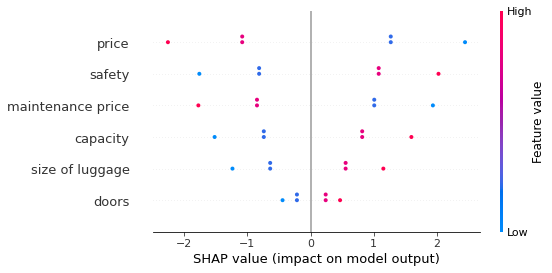

In [28]:
svm_shaps = svm_explainer(alts_filtered)
shap.summary_plot(svm_shaps,alts_filtered,feature_names=data_classless.columns)

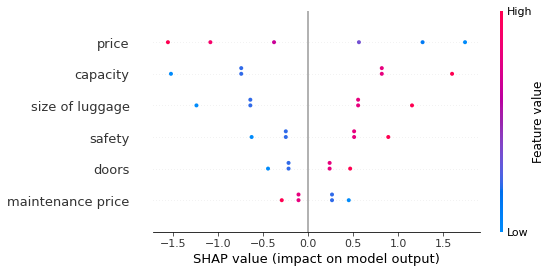

In [29]:
svm_shaps = svm_explainer(alts_filtered2)
shap.summary_plot(svm_shaps,alts_filtered2,feature_names=data_classless.columns)

As this is a linear model, the dependencies of the criterions on the sorted class is also linear.

In [30]:
pd_res = partial_dependence(rank_svm,X_test_filtered,np.arange(features))

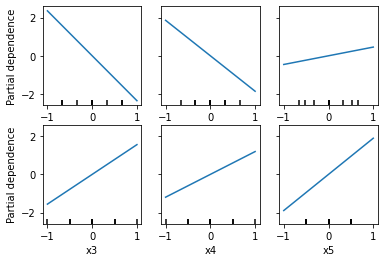

In [31]:
PartialDependenceDisplay.from_estimator(rank_svm,X_test_filtered,np.arange(features));

## Tensorflow solutions

### ANN-UTADIS

In [32]:
threshold = 0.75
ideal_alt = [0,0,1,1,1,1]
antiideal_alt = [1,1,0,0,0,0]

In [33]:
uta_model = create_ann_utadis_model(threshold,ideal_alt,antiideal_alt,classes,features,L=7)
uta_model.build(input_shape=(None,features))
uta_model.summary()

Model: "norm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ann_utadis (Functional)         │ ?                      │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ thresholder (Thresholder)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132 (528.00 B)

 Trainable params: 132 (528.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
uta_model.uta.summary()

Model: "ann_utadis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ criteria_0 (Lambda) │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ criteria_1 (Lambda) │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ criteria_2 (Lambda) │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ criteria_3 (Lambda) │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ criteria_4 (Lambda) │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ criteria_5 (Lambda) │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ monotone_block_0    │ (None, 1)         │         21 │ criteria_0[0][0]  │
│ (MonotoneBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ monotone_block_1    │ (None, 1)         │         21 │ criteria_1[0][0]  │
│ (MonotoneBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ monotone_block_2    │ (None, 1)         │         21 │ criteria_2[0][0]  │
│ (MonotoneBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ monotone_block_3    │ (None, 1)         │         21 │ criteria_3[0][0]  │
│ (MonotoneBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ monotone_block_4    │ (None, 1)         │         21 │ criteria_4[0][0]  │
│ (MonotoneBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ monotone_block_5    │ (None, 1)         │         21 │ criteria_5[0][0]  │
│ (MonotoneBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 6)         │          0 │ monotone_block_0… │
│ (Concatenate)       │                   │            │ monotone_block_1… │
│                     │                   │            │ monotone_block_2… │
│                     │                   │            │ monotone_block_3… │
│                     │                   │            │ monotone_block_4… │
│                     │                   │            │ monotone_block_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ criteria_weights    │ (None, 1)         │          6 │ concatenate_6[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 132 (528.00 B)

 Trainable params: 132 (528.00 B)

 Non-trainable params: 0 (0.00 B)

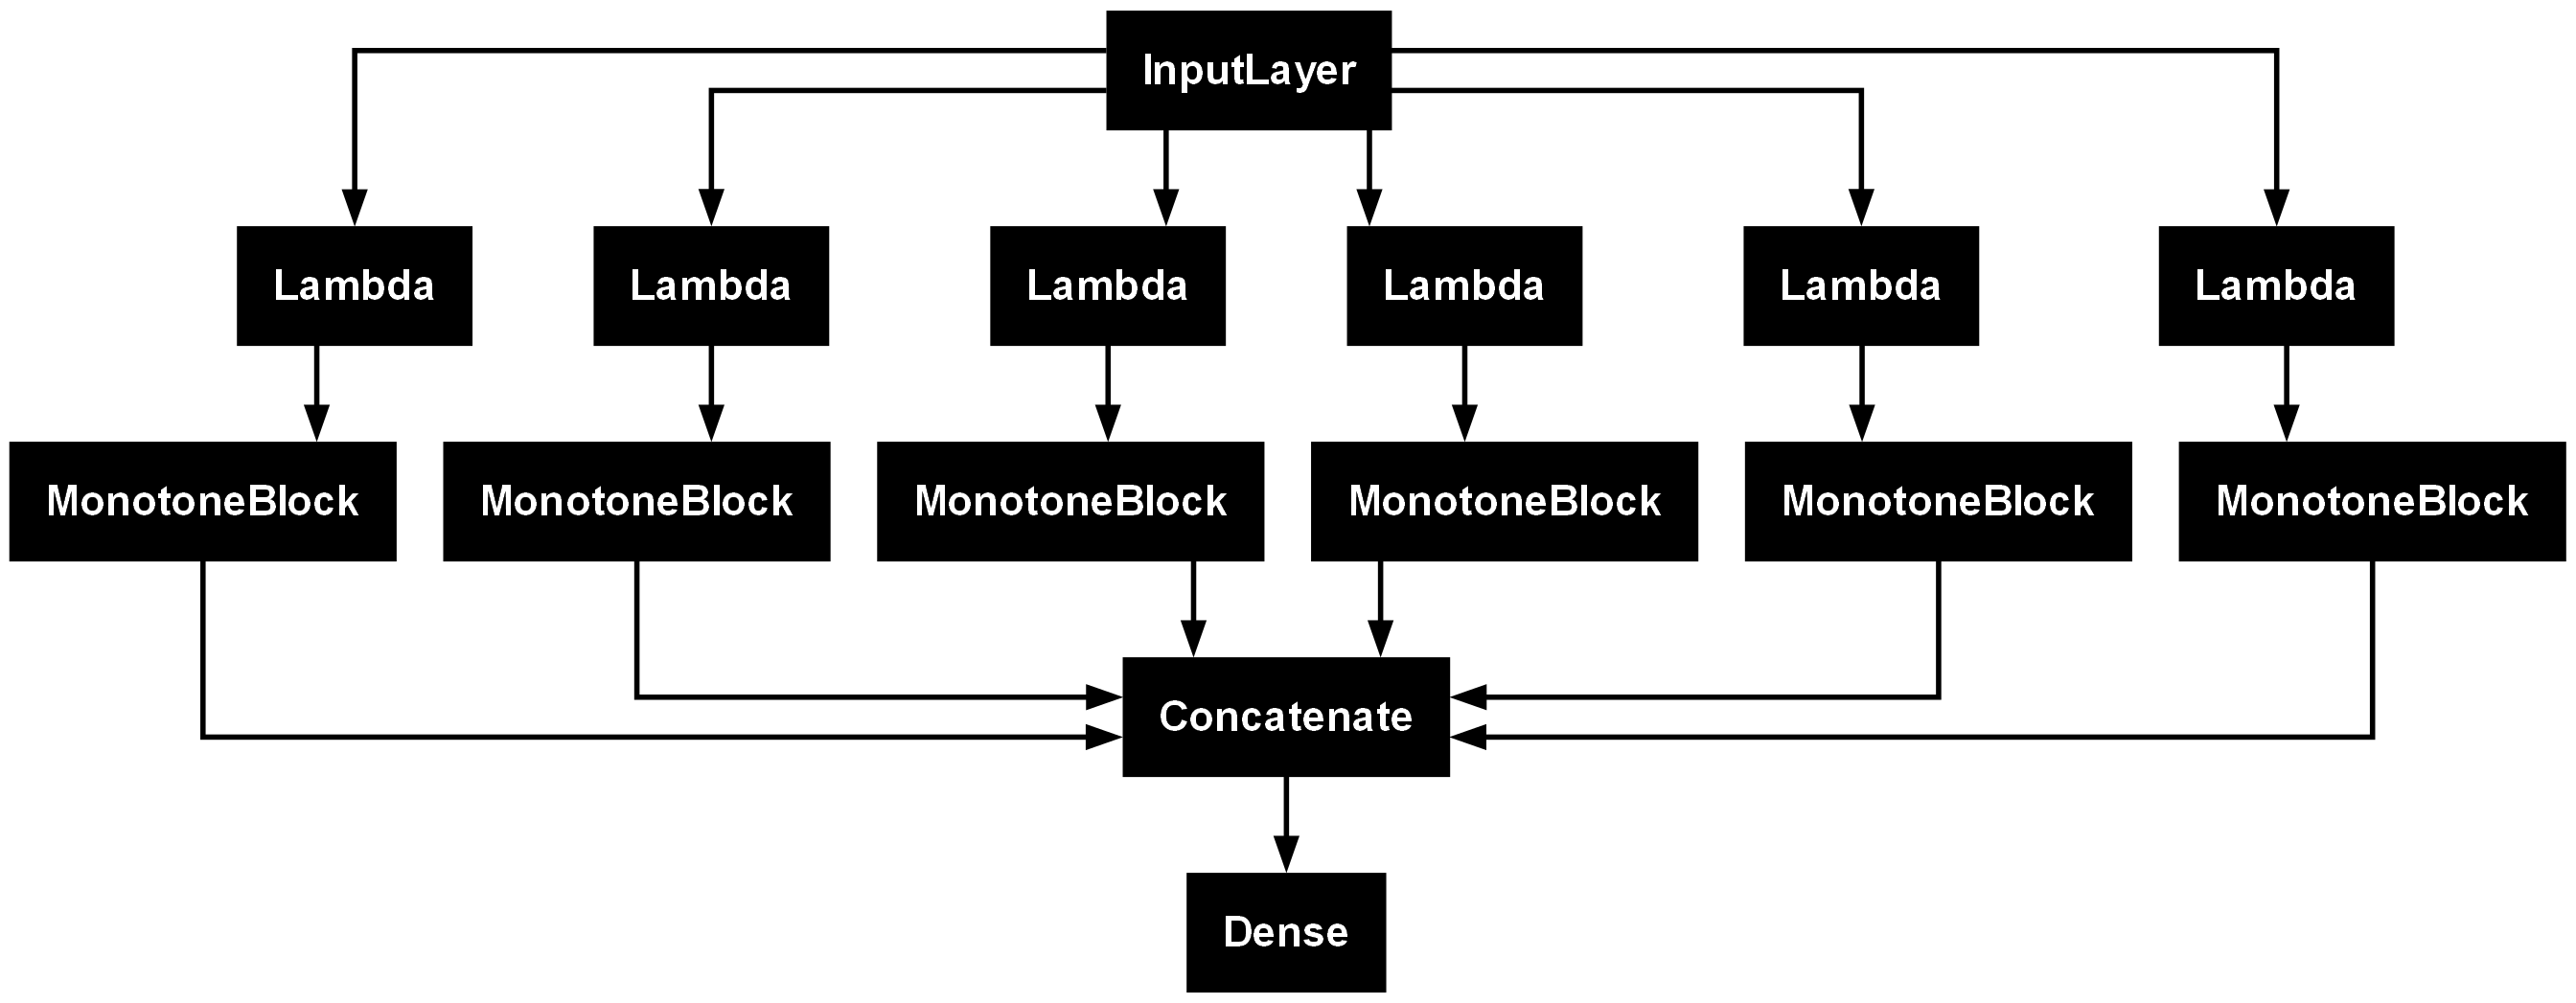

In [35]:
plot_model(uta_model.uta)

In [36]:
history = train(uta_model,X_train,y_train,mean_regret,
                val_data=(X_val,y_val),
                batch=len(X_train),
                epochs=200,
                patience=10,
                metrics=[UtilMetric(Accuracy()),UtilMetric(AUC(name="auc")),UtilMetric(F1Score())])

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.7125 - auc: 0.7125 - f1_score: 0.6714 - loss: 0.1007 - val_accuracy: 0.7037 - val_auc: 0.7103 - val_f1_score: 0.6837 - val_loss: 0.0627
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6375 - auc: 0.6375 - f1_score: 0.6757 - loss: 0.0635 - val_accuracy: 0.7037 - val_auc: 0.7103 - val_f1_score: 0.6808 - val_loss: 0.0621
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6375 - auc: 0.6375 - f1_score: 0.6767 - loss: 0.0627 - val_accuracy: 0.7037 - val_auc: 0.7103 - val_f1_score: 0.6799 - val_loss: 0.0615
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6438 - auc: 0.6438 - f1_score: 0.6779 - loss: 0.0619 - val_accuracy: 0.7037 - val_auc: 0.7103 - val_f1_score: 0.6802 - val_loss: 0.0609
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6438 - auc: 0.6438 - f1_score: 0.6786 - loss: 0.0611 - val_accuracy: 0.7037 - val_auc: 0.7103 - val_f1_score: 0.6804 - val_loss: 0.0603


#### ANN-UTADIS analysis

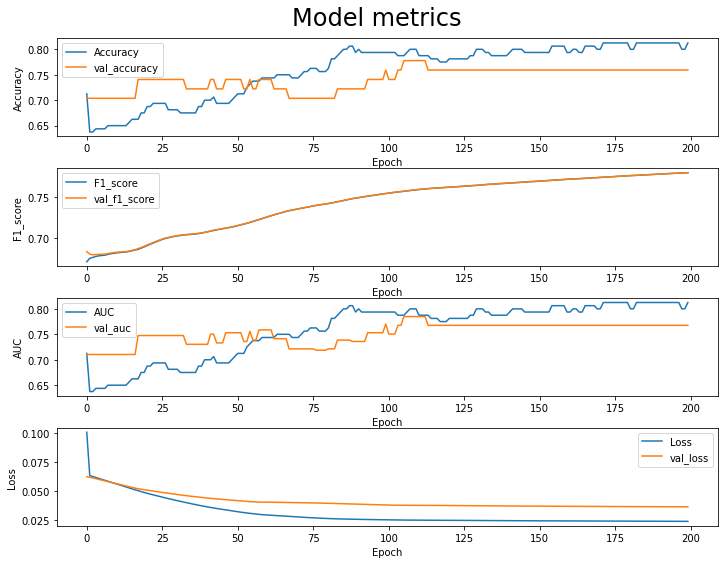

In [37]:
show_history(history)

In [38]:
show_tensor_stats(y_test,uta_model.predict(X_test)>0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
Accuracy: 74.0741%
AUC: 73.3793%
F1 Score: 77.4194%


This model does not seem to be really stable. Sometimes it produces low accuracy solutions and sometimes high accuracy solutions.

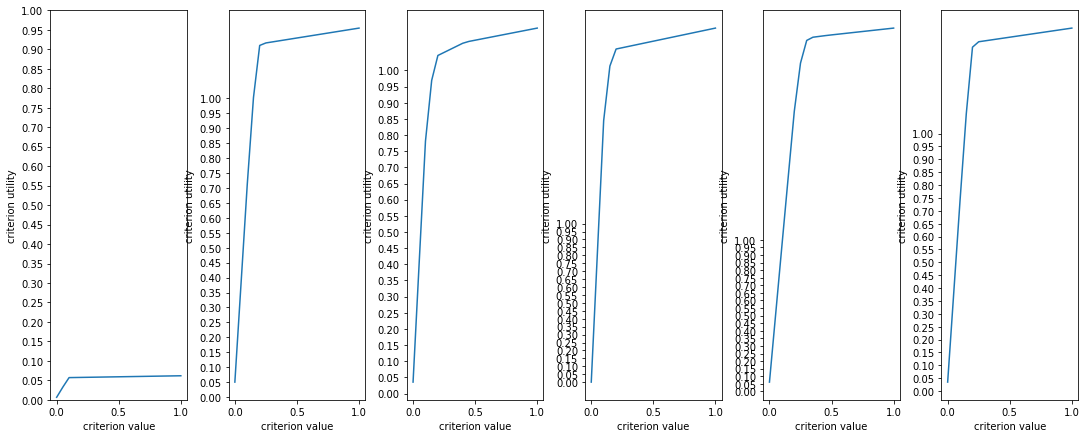

In [39]:
show_monotone_blocks(uta_model.uta,features)

The monotonic layers often break around criterion value of 0.5 as the unique values for the last three criteria are 0, 0.5 and 1.0

For the first three the unique values are 0.0, 0.33,0.66 and 1.0, however the weights mute their channels.

In [40]:
show_criteria_weights(uta_model)

Weight of criterion 0 : 0.114551194
Weight of criterion 1 : -0.0
Weight of criterion 2 : 0.27411032
Weight of criterion 3 : 0.14356562
Weight of criterion 4 : 0.12776035
Weight of criterion 5 : 0.2452279


The weights of the criteria are different based on the run, however the first two criteria usually get low weight values as the model is only able to model gain criteria.

##### Decisions

In [41]:
for alt,p in zip(alts,uta_model.predict(alts,verbose=0)):
    print(f"Alternative: {alt}")
    print(f"Class: {p[0]>0}")
    print(f"Score: {p[0]+threshold:.4f}")
    print()

Alternative: [0. 0. 1. 1. 1. 1.]
Class: True
Score: 1.0000

Alternative: [1. 1. 0. 0. 0. 0.]
Class: False
Score: 0.0000

Alternative: [0.5 0.5 0.5 0.5 0.5 0.5]
Class: True
Score: 0.9756



The results don't agree with predictins as other criterions also were needed to be changed.

In [42]:
explainer = shap.KernelExplainer(lambda x: uta_model.predict(x,verbose=0),X_train)

Using 160 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/3 [00:00<?, ?it/s]

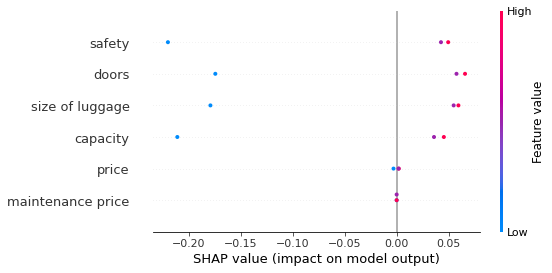

In [43]:
uta_shap_values = explainer.shap_values(alts)
shap.summary_plot(uta_shap_values[:,:,0], alts,feature_names=data_classless.columns)

Because of the muted price criteria, they have no influence. To change the evaluation of the data, other criteria must be changed. Their weights are somewhat equal so it does not matter which ones.

In this case pushing the value of safety to minimum or maximum could change the evaluation.

The changes should probably be over the unique breakpoints as these are the most significant.

In [72]:
uta_difs = np.array([
    [0,0,-0,0,0,-1],
    [0,0,0,1,1,1],
    [0,0,0,0,0,-0.5],
])

for alt,p in zip(alts+uta_difs,uta_model.predict(alts+uta_difs,verbose=0)):
    print(f"Alternative: {alt}")
    print(f"Class: {p[0]>0}")
    print(f"Score: {p[0]+threshold:.4f}")
    print()

Alternative: [0. 0. 1. 1. 1. 0.]
Class: False
Score: 0.7303

Alternative: [1. 1. 0. 1. 1. 1.]
Class: True
Score: 0.7648

Alternative: [0.5 0.5 0.5 0.5 0.5 0. ]
Class: False
Score: 0.7129



Slightly changing the values.

  0%|          | 0/3 [00:00<?, ?it/s]

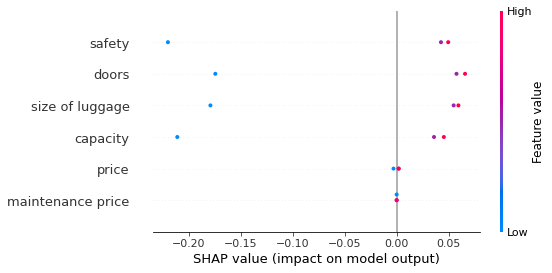

In [45]:
uta_shap_values = explainer.shap_values(alts)
shap.summary_plot(uta_shap_values[:,:,0], alts,feature_names=data_classless.columns)

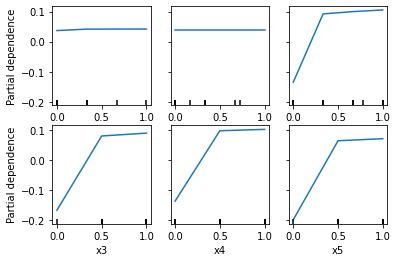

In [46]:
wrapped = KerasClassifier(uta_model,verbose=0)
wrapped.initialize(X_train,y_train)
PartialDependenceDisplay.from_estimator(wrapped,X_test,np.arange(features));

The dependence is often not linear as it depends on the shape of  monotonic layers.

### Conventional Neural Network

In [47]:
nn_model = create_nn_model(features)

nn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

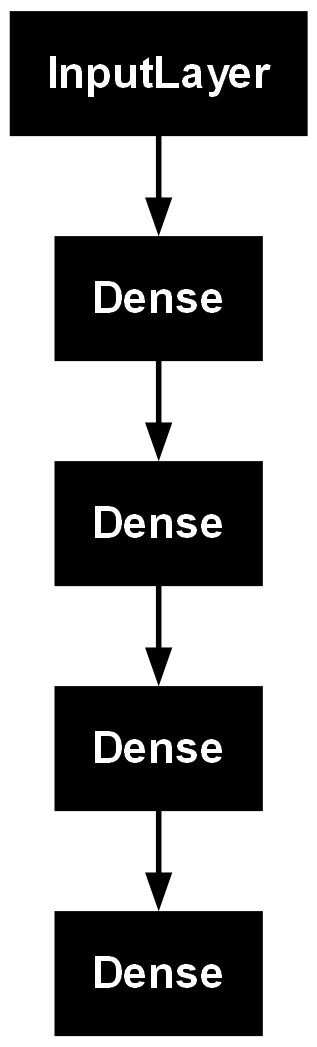

In [48]:
plot_model(nn_model)

In [49]:
history = train(nn_model,X_train,y_train,"binary_crossentropy",val_data=(X_val,y_val),patience=3,epochs=50)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5423 - auc: 0.4713 - f1_score: 0.1685 - loss: 0.6904 - val_accuracy: 0.8889 - val_auc: 0.9752 - val_f1_score: 0.8929 - val_loss: 0.6175
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9083 - auc: 0.9844 - f1_score: 0.9073 - loss: 0.5915 - val_accuracy: 0.9259 - val_auc: 0.9772 - val_f1_score: 0.9259 - val_loss: 0.4940
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9385 - auc: 0.9811 - f1_score: 0.9420 - loss: 0.4575 - val_accuracy: 0.9630 - val_auc: 0.9800 - val_f1_score: 0.9615 - val_loss: 0.3448
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9469 - auc: 0.9739 - f1_score: 0.9507 - loss: 0.3366 - val_accuracy: 0.9259 - val_auc: 0.9759 - val_f1_score: 0.9259 - val_loss: 0.2594
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9356 - auc: 0.9915 - f1_score: 0.9436 - loss: 0.2269 - val_accuracy: 0.9630 - val_auc: 0.9793 - val_f1_score: 0.9615 - val_loss: 0.1764

#### Neural Network Analysis

As expected the neural network is able to gain very high scores in accuracy and other metrics, with some runs and with tweaking the threshold, even values of 100% are possible.

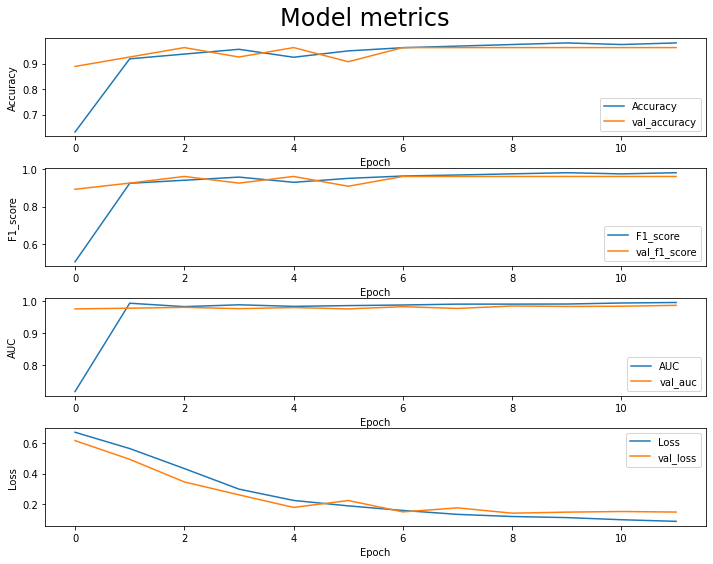

In [50]:
show_history(history)

In [51]:
show_tensor_stats(y_test,nn_model.predict(X_test)>0.5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Accuracy: 98.1481%
AUC: 98.0000%
F1 Score: 98.3051%


##### Decisions

Unfortunately because the model is a black box, to analyse the results a guided gradient has to be used, which is hard to interpret.

In [52]:
guided = create_guided_model(nn_model)

In [79]:
for alt in alts:
    print("Alternative:",alt)

    with tf.GradientTape() as tape:
        inputs = tf.cast(tf.reshape(alt,(1,6)),tf.float32)
        tape.watch(inputs)
        pred = guided(inputs)

    grads = tape.gradient(pred,inputs)

    print(f"Predicted class: {np.max(pred.numpy()):.4%}")

    for i,g in enumerate(grads.numpy()[0]):
        print(f"Gradient of feature {i}: {g:.4e}")
    print()

Alternative: [0. 0. 1. 1. 1. 1.]
Predicted class: 99.6739%
Gradient of feature 0: -4.0251e-03
Gradient of feature 1: -1.9986e-03
Gradient of feature 2: 3.1809e-03
Gradient of feature 3: 4.1741e-03
Gradient of feature 4: 3.9306e-03
Gradient of feature 5: 6.1027e-03

Alternative: [1. 1. 0. 0. 0. 0.]
Predicted class: 0.0058%
Gradient of feature 0: -2.6908e-04
Gradient of feature 1: -2.0250e-04
Gradient of feature 2: -2.9046e-05
Gradient of feature 3: 4.0926e-05
Gradient of feature 4: -8.6194e-06
Gradient of feature 5: 4.6425e-05

Alternative: [0.5 0.5 0.5 0.5 0.5 0.5]
Predicted class: 0.8158%
Gradient of feature 0: -5.7115e-02
Gradient of feature 1: -4.3530e-02
Gradient of feature 2: 5.5123e-03
Gradient of feature 3: 1.2891e-02
Gradient of feature 4: 9.4793e-03
Gradient of feature 5: 2.3926e-02



From the gradients it can be observed which values have to be changed in order for the predictions to change.

Most important change to single criterion for alternative i:

1. the safety(feature 5),
2. the price(feature 0),
3. the price(feature 0)

And they involve pushing them to the marginal values.

The changes should probably be over the unique breakpoints as these are the most significant.

In [86]:
nn_difs = np.array([
    [0.5,0,0,-1,0,-1],
    [-1,-1,0,0.6,0,0.6],
    [0.5,0.5,0,0,0,0]
])


for alt,p in zip(alts+nn_difs,nn_model.predict(alts+nn_difs,verbose=0)):
    print(f"Changed alt: {alt}")
    print(f"Likelihood of class 1: {p[0]:0.4%}")
    print()

Changed alt: [0.5 0.  1.  0.  1.  0. ]
Likelihood of class 1: 0.6888%

Changed alt: [0.  0.  0.  0.6 0.  0.6]
Likelihood of class 1: 81.6873%

Changed alt: [1.  1.  0.5 0.5 0.5 0.5]
Likelihood of class 1: 0.0089%



The results don't agree with predictins as other criterions also were needed to be changed.

In [73]:
explainer = shap.KernelExplainer(lambda x: nn_model.predict(x,verbose=0),X_train[:50])

  0%|          | 0/3 [00:00<?, ?it/s]

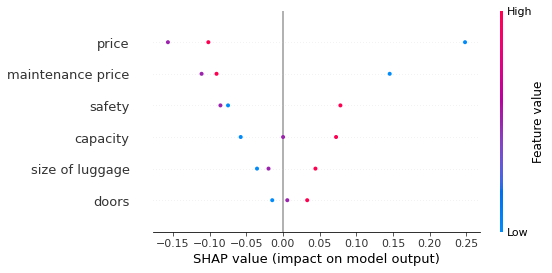

In [74]:
shap_values = explainer.shap_values(alts)
shap.summary_plot(shap_values[:,:,0], alts,feature_names=data_classless.columns)

The shapley values are quite similar to the gradients shown before.

  0%|          | 0/3 [00:00<?, ?it/s]

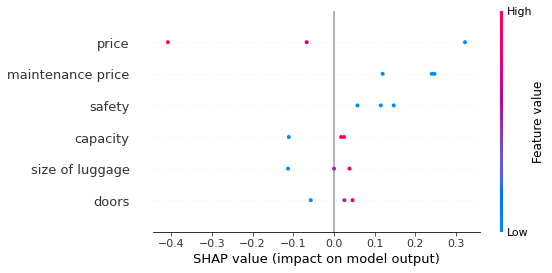

In [75]:
shap_values = explainer.shap_values(alts+nn_difs)
shap.summary_plot(shap_values[:,:,0], alts+nn_difs,feature_names=data_classless.columns)

This model shows the most interesting dependencies of the model on the criterions. However still all of them are monotonic.

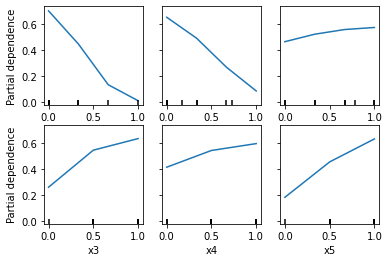

In [77]:
wrapped = KerasClassifier(nn_model,verbose=0)
wrapped.initialize(X_train,y_train)
PartialDependenceDisplay.from_estimator(wrapped,X_test,np.arange(features));

## Summary

The models performed really well, especially the neural network, at the cost of being hard to interpret(guided gradient).

The ANN UTA model, altough interpretable, does not produce consistent results.

### User Preferences

The decision maker prefers:
- affordable cars,
- with cheap maintanance,
- that are safe

Other features like capacity and luggage are important, but they are not often the key.

So the price criterias are expectedly cost type. The rest of the criteria are gain type, with doors being the least important overall.

## References


[1] Fallah Tehrani, Ali & Cheng, Weiwei & Hüllermeier, Eyke. (2011). Choquistic Regression: Generalizing Logistic Regression using the Choquet Integral. 10.2991/eusflat.2011.86., page 6